# Machine Learing Exam

Lucho Jun|2025<br>
The scientist by Coldplay

## Consigna

### Problema de Retención de Clientes en el Banco PY

Se desea resolver el siguiente problema: 

El banco PY está notando que muchos clientes se están acercando a cerrar su cuenta, lo cual les preocupa. Decidieron implementar una estrategia de retención muy agresiva que, a su vez, es costosa ya que bonifica productos y otorga descuentos que no se ven normalmente en el mercado. 

Se ha observado en un pequeño experimento que, a pesar de ser una oferta irresistible, cuando un cliente le indica al banco que se quiere dar de baja, ya no hay vuelta atrás. Por esta razón, se desea que los ejecutivos sepan con anticipación cuándo un cliente tiene altas probabilidades de pedir la baja, a pesar de que el motivo de acercarse al banco sea otro. De esta manera, al recibir al cliente, ya se pueden preparar para retenerlos.

#### Descripción Operativa

Cuando un cliente entra en una sucursal, tiene un tótem en donde se registra e indica el motivo de su visita. Esto le genera el turno y, con él, espera a ser atendido por un ejecutivo. 

El banco posee varias sucursales en Asunción que se gestionan en dos zonas: una céntrica y otra en las afueras. Esta definición no solo tiene que ver con la locación, sino también con el comportamiento y la tolerancia de los clientes.

Hoy en día, el equipo de Data Science tiene funcionando un modelo, pero no es suficientemente bueno para la nueva estrategia que propone el equipo comercial, por lo que desean reemplazarlo por uno nuevo.

#### Objetivos

* Desarrollar un modelo de Machine Learning que prediga churn.
* Definir cómo sería la implementación y cuándo se usaría.
* Explicar la elección del algoritmo utilizado
* Explicar los resultados obtenidos (Métricas) y si tiene el rendimiento necesario para salir a producción.
* Explicar cuales son las variables que más afectan a la predicción.
* Contestar las siguientes preguntas:
  * *¿El modelo final elegido es bueno? Justificar*
  * *¿Existe overfitting o underfitting?* 

⚠️**ACLARACIONES:**⚠️

- Se tendrá en cuenta la prolijidad del informe. 
- Se tendrá en cuenta la legibilidad del código.
- De ser necesario, dejar asentado los supuestos utilizados por escrito.

#### Recursos Disponibles

Para resolver el desafío, se cuenta con:

- Un dataset que contiene las visitas de nuestros clientes a las sucursales y otro de zonas. Esta información consta de datos obtenidos del tótem y del CRM del ejecutivo.
- Un modelo actual (función de Python para hacer predicciones).
- Datos de costo promedio de la estrategia de retención y rentabilidad esperada del cliente en los 3 primeros meses luego de retenerlo, rentabilidad esperada del cliente en el primer año luego de retenerlo, y rentabilidad del cliente en la última acción de darse de baja.

#### Descripción del dataset
- cliente_id: id del cliente que se registra en el totem de la sucursal
- segmento_cliente: segmento del cliente, se obtiene con un modelo de ML que segmenta a los clientes según su comportamiento
- tipo_asistencia: la accion que declara el cliente que viene a hacer al banco cuando se registra en el totem. En los últimos meses de volvió opcional
- descripcion_atencion: cuando el cliente se registra le dice al totem con su voz qué es lo que viene a hacer al banco, un modelo de IA lo traduce en tiempo real. El cliente también tiene la opción de hacerlo escribiendo en un teclado.
- coordenadas_sucursal: coordenadas geográficas en donde se encuentra la sucursal de la atención
- inicio_atencion_utc: fecha y hora de inicio de llegada a la sucursa (registro en totem). El huso horario es UTC+0
- fin_atencion: fecha y hora de fin de atención marcada desde el CRM del ejecutivo cuando cierra la atención. El huso horario es UTC-3 hora de Paraguay
- puntos_de_loyalty: puntos acumulados en el sistema de loyalty
- edad: edad del cliente
- churn: indica si luego de la atención el cliente se dio de baja del banco o no. Se completa automáticamente desde el CRM por el ejecutivo.

- zona: nombre de la zona de atención
- poligono: coordenadas del contorno del polígono correspondiente a cada zona

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import polars as pl
from shapely.geometry import Point, Polygon, shape
from shapely import wkb
import json
import ast
import contextily as ctx
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from folium.plugins import MarkerCluster
import folium
import plotly.express as px
import random
from scipy.stats import randint
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score,accuracy_score,
                            precision_score,recall_score,f1_score,roc_curve)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold,cross_val_score
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier,plot_tree
import joblib
from sklearn.model_selection import learning_curve
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
import pyarrow as pa
import nltk
from nltk.corpus import stopwords

In [2]:
# Definición de costos y rentabilidades
costo_retencion = 20
rentabilidad_corto = 8
rentabilidad_largo = 50
rentabilidad_baja = -2

### Import dataset

In [3]:
visitas = pd.read_csv(r"dataset_churn_challenge.csv",low_memory=False)
visitas_raw = visitas.copy()
visitas.head()

,cliente_id,segmento_cliente,tipo_asistencia,descripcion_atencion,coordenadas_sucursal,inicio_atencion_utc,fin_atencion,puntos_de_loyalty,edad,churn
0,12462,C2,soporte,Estoyaquí Para pedir ayudacon Un Error Tuerca ...,"{""latitud"": -57.58450957047116, ""longitud"": -2...",2024-01-01 17:52:00+00:00,2024-01-01 15:08:39.861786534,3149.471104,40,True
1,7471,B1,soporte,vengo Porqu Necesito Asistencia Con Mi Tarjeta...,"{""latitud"": -57.5845748190944, ""longitud"": -25...",2024-01-01 13:00:00+00:00,2024-01-01 10:31:01.452232488,5327.590530,51,False
2,43237,D3,problema,Estoy aquí Porque mi cuenta ha sido Bloqueada,"{""latitud"": -57.58479480189594, ""longitud"": -2...",2024-01-01 14:45:00+00:00,2024-01-01 12:17:10.491604314,3105.681258,47,False
3,25235,C7,consulta,Estoy interesado e Saber Másobre losbeneficios...,"{""latitud"": -57.584313344292916, ""longitud"": -...",2024-01-01 18:58:00+00:00,2024-01-01 16:17:54.884666088,3063.190862,33,False
4,68218,B8,consulta,Necesito idea sobre cómo Cambiar Mis datos per...,"{""latitud"": -57.58508148218123, ""longitud"": -2...",2024-01-01 18:20:00+00:00,2024-01-01 15:36:38.272183704,6113.842796,47,False


In [4]:
zonas = pd.read_csv(r"dataset_churn_zona_challenge.csv")
zonas_raw = zonas.copy()
zonas.head(5)

,zona,poligono
0,zona_1,"[(-25.301188661136475, -57.5845342836452), (-2..."
1,zona_2,"[(-25.300874738675326, -57.5845342836452), (-2..."


In [5]:
## Valores faltantes de visitas
percent_missing = visitas.isnull().sum() * 100 / len(visitas)
missing_value_df = pd.DataFrame({'column_name': visitas.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
cliente_id,cliente_id,0.000000
segmento_cliente,segmento_cliente,0.000000
tipo_asistencia,tipo_asistencia,19.138836
descripcion_atencion,descripcion_atencion,0.000000
coordenadas_sucursal,coordenadas_sucursal,0.000000
inicio_atencion_utc,inicio_atencion_utc,0.000000
fin_atencion,fin_atencion,0.000000
puntos_de_loyalty,puntos_de_loyalty,0.000000
edad,edad,0.000000
churn,churn,0.000000


In [6]:
#Ver si hay datos duplicados
visitas.duplicated().sum()

0

In [7]:
## Valores faltantes de zonas
percent_missing = zonas_raw.isnull().sum() * 100 / len(zonas_raw)
missing_value_df = pd.DataFrame({'column_name': zonas_raw.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
zona,zona,0.0
poligono,poligono,0.0


In [8]:
zonas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   zona      2 non-null      object
 1   poligono  2 non-null      object
dtypes: object(2)
memory usage: 164.0+ bytes


In [9]:
def explore_data(df):
    print("\nInformación del dataset:")
    print(visitas.info())
    print("\nValores nulos:")
    print(visitas.isnull().sum())
    print("\nDescripción estadística:")
    print(visitas.describe())

explore_data(visitas)


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765731 entries, 0 to 765730
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cliente_id            765731 non-null  int64  
 1   segmento_cliente      765731 non-null  object 
 2   tipo_asistencia       619179 non-null  object 
 3   descripcion_atencion  765731 non-null  object 
 4   coordenadas_sucursal  765731 non-null  object 
 5   inicio_atencion_utc   765731 non-null  object 
 6   fin_atencion          765731 non-null  object 
 7   puntos_de_loyalty     765731 non-null  float64
 8   edad                  765731 non-null  int64  
 9   churn                 765731 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 53.3+ MB
None

Valores nulos:
cliente_id                   0
segmento_cliente             0
tipo_asistencia         146552
descripcion_atencion         0
coordenadas_sucursal  

NOTA: Luego de hacer un mini analisis, se comienza con el merge de los datasets.

In [10]:
print(visitas['coordenadas_sucursal'].head(10))
print(visitas['coordenadas_sucursal'].apply(type).value_counts())

0    {"latitud": -57.58450957047116, "longitud": -2...
1    {"latitud": -57.5845748190944, "longitud": -25...
2    {"latitud": -57.58479480189594, "longitud": -2...
3    {"latitud": -57.584313344292916, "longitud": -...
4    {"latitud": -57.58508148218123, "longitud": -2...
5    {"latitud": -57.5844891609809, "longitud": -25...
6    {"latitud": -57.58464742514163, "longitud": -2...
7    {"latitud": -57.58488855570603, "longitud": -2...
8    {"latitud": -57.584185998966404, "longitud": -...
9    {"latitud": -57.58464742514163, "longitud": -2...
Name: coordenadas_sucursal, dtype: object
coordenadas_sucursal
<class 'str'>    765731
Name: count, dtype: int64


In [11]:
visitas.describe(include="all")

,cliente_id,segmento_cliente,tipo_asistencia,descripcion_atencion,coordenadas_sucursal,inicio_atencion_utc,fin_atencion,puntos_de_loyalty,edad,churn
count,765731.000000,765731,619179,765731,765731,765731,765731,765731.000000,765731.000000,765731
unique,NaN,31,4,732022,35,117075,765566,NaN,NaN,2
top,NaN,C4,consulta,Necesito Asesoramiento Sobre Ahorro para Mi ju...,"{""latitud"": -57.58443665121567, ""longitud"": -2...",2025-01-29 17:36:00+00:00,2025-01-06 14:25:00.000000000,NaN,NaN,False
freq,NaN,38142,247318,27,27473,23,3,NaN,NaN,537713
mean,133550.964887,NaN,NaN,NaN,NaN,NaN,NaN,4851.133035,42.553482,NaN
std,82501.294565,NaN,NaN,NaN,NaN,NaN,NaN,1025.265643,9.957738,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,123.473670,18.000000,NaN
25%,63559.000000,NaN,NaN,NaN,NaN,NaN,NaN,4159.488868,36.000000,NaN
50%,127347.000000,NaN,NaN,NaN,NaN,NaN,NaN,4853.554087,43.000000,NaN
75%,197961.500000,NaN,NaN,NaN,NaN,NaN,NaN,5544.878457,49.000000,NaN


In [12]:
# Procesar coordenadas de sucursal (convertir de string JSON a lat/lon)
visitas['coordenadas_dict'] = visitas['coordenadas_sucursal'].apply(json.loads)
visitas['latitud'] = visitas['coordenadas_dict'].apply(lambda x: x['latitud'])
visitas['longitud'] = visitas['coordenadas_dict'].apply(lambda x: x['longitud'])

In [13]:
#Procesar polígonos de zonas
# Convertir el string a lista de coordenadas 
try:
    zonas['poligono'] = zonas['poligono'].apply(ast.literal_eval)
except:
    pass  

# Crear objetos Polygon de Shapely
zonas['geometry'] = zonas['poligono'].apply(lambda x: Polygon(x))

In [14]:
# Crear GeoDataFrames
gdf_visitas = gpd.GeoDataFrame(
    visitas,
    geometry=gpd.points_from_xy(visitas['longitud'], visitas['latitud']),
    crs="EPSG:4326"  
)

gdf_zonas = gpd.GeoDataFrame(
    zonas,
    geometry='geometry',
    crs="EPSG:4326"
)
#Realizar la unión espacial
df_final = gpd.sjoin(
    gdf_visitas,
    gdf_zonas[['zona', 'geometry']],  
    how='left',
    predicate='within'
)

# Renombrar columnas para claridad
df_final = df_final.rename(columns={'zona': 'zona_sucursal'})

# Seleccionar columnas relevantes
columnas_finales = [
    'cliente_id', 'segmento_cliente', 'tipo_asistencia', 
    'descripcion_atencion', 'inicio_atencion_utc', 'fin_atencion',
    'puntos_de_loyalty', 'edad', 'churn', 'zona_sucursal', 'geometry'
]
df_final = df_final[columnas_finales]

In [15]:
df_final.head()

,cliente_id,segmento_cliente,tipo_asistencia,descripcion_atencion,inicio_atencion_utc,fin_atencion,puntos_de_loyalty,edad,churn,zona_sucursal,geometry
0,12462,C2,soporte,Estoyaquí Para pedir ayudacon Un Error Tuerca ...,2024-01-01 17:52:00+00:00,2024-01-01 15:08:39.861786534,3149.471104,40,True,zona_1,POINT (-25.30126 -57.58451)
1,7471,B1,soporte,vengo Porqu Necesito Asistencia Con Mi Tarjeta...,2024-01-01 13:00:00+00:00,2024-01-01 10:31:01.452232488,5327.590530,51,False,zona_1,POINT (-25.30168 -57.58457)
2,43237,D3,problema,Estoy aquí Porque mi cuenta ha sido Bloqueada,2024-01-01 14:45:00+00:00,2024-01-01 12:17:10.491604314,3105.681258,47,False,zona_1,POINT (-25.30169 -57.58479)
3,25235,C7,consulta,Estoy interesado e Saber Másobre losbeneficios...,2024-01-01 18:58:00+00:00,2024-01-01 16:17:54.884666088,3063.190862,33,False,zona_1,POINT (-25.30138 -57.58431)
4,68218,B8,consulta,Necesito idea sobre cómo Cambiar Mis datos per...,2024-01-01 18:20:00+00:00,2024-01-01 15:36:38.272183704,6113.842796,47,False,zona_2,POINT (-25.30185 -57.58508)


In [16]:
df = df_final.copy()
df1 = df_final.copy()
df.head()

,cliente_id,segmento_cliente,tipo_asistencia,descripcion_atencion,inicio_atencion_utc,fin_atencion,puntos_de_loyalty,edad,churn,zona_sucursal,geometry
0,12462,C2,soporte,Estoyaquí Para pedir ayudacon Un Error Tuerca ...,2024-01-01 17:52:00+00:00,2024-01-01 15:08:39.861786534,3149.471104,40,True,zona_1,POINT (-25.30126 -57.58451)
1,7471,B1,soporte,vengo Porqu Necesito Asistencia Con Mi Tarjeta...,2024-01-01 13:00:00+00:00,2024-01-01 10:31:01.452232488,5327.590530,51,False,zona_1,POINT (-25.30168 -57.58457)
2,43237,D3,problema,Estoy aquí Porque mi cuenta ha sido Bloqueada,2024-01-01 14:45:00+00:00,2024-01-01 12:17:10.491604314,3105.681258,47,False,zona_1,POINT (-25.30169 -57.58479)
3,25235,C7,consulta,Estoy interesado e Saber Másobre losbeneficios...,2024-01-01 18:58:00+00:00,2024-01-01 16:17:54.884666088,3063.190862,33,False,zona_1,POINT (-25.30138 -57.58431)
4,68218,B8,consulta,Necesito idea sobre cómo Cambiar Mis datos per...,2024-01-01 18:20:00+00:00,2024-01-01 15:36:38.272183704,6113.842796,47,False,zona_2,POINT (-25.30185 -57.58508)


In [17]:
df.shape

(765731, 11)

In [18]:
n_clientes = df["cliente_id"].nunique()
print(f"Cantidad total de clientes únicos: {n_clientes}")

Cantidad total de clientes únicos: 297885


In [19]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 765731 entries, 0 to 765730
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   cliente_id            765731 non-null  int64   
 1   segmento_cliente      765731 non-null  object  
 2   tipo_asistencia       619179 non-null  object  
 3   descripcion_atencion  765731 non-null  object  
 4   inicio_atencion_utc   765731 non-null  object  
 5   fin_atencion          765731 non-null  object  
 6   puntos_de_loyalty     765731 non-null  float64 
 7   edad                  765731 non-null  int64   
 8   churn                 765731 non-null  bool    
 9   zona_sucursal         765731 non-null  object  
 10  geometry              765731 non-null  geometry
dtypes: bool(1), float64(1), geometry(1), int64(2), object(6)
memory usage: 65.0+ MB


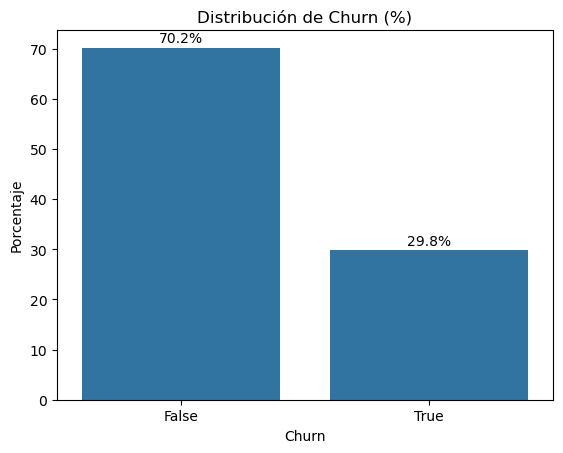

Proporción de churn: 29.78%


In [20]:
# Distribución de churn
churn_dist = df['churn'].value_counts(normalize=True) * 100

sns.barplot(x=churn_dist.index, y=churn_dist.values)
plt.title('Distribución de Churn (%)')
plt.ylabel('Porcentaje')
plt.xlabel('Churn')
for i, v in enumerate(churn_dist.values):
    plt.text(i, v+1, f"{v:.1f}%", ha='center')
plt.show()


print(f"Proporción de churn: {churn_dist.iloc[1]:.2f}%")

Aca se puede observar, como posibles hipotesis de la variable target:
- Alto riesgo operativo: Un 30% de abandono es extremadamente preocupante para cualquier banco, ya que lo normal es el valor entre el 5 y 15 anual
- Impacto financiero: Con esta tasa, el banco estaría perdiendo casi 1/3 de su base de clientes periódicamente.
- Segmentos críticos: Algunos grupos podrían tener >50% churn
- Clientes valiosos: El 30% incluye probablemente a clientes rentables

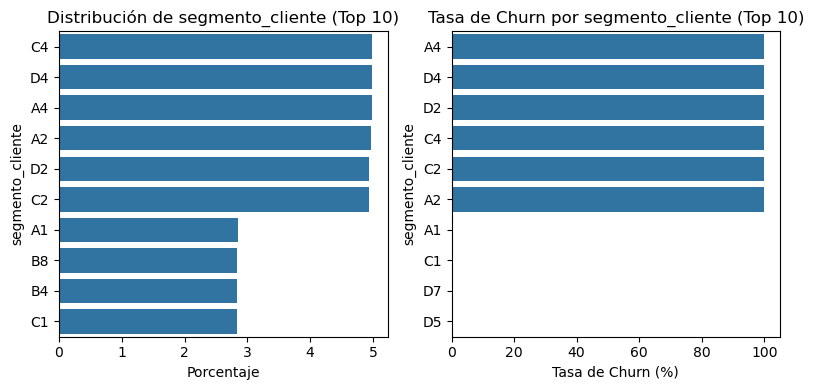

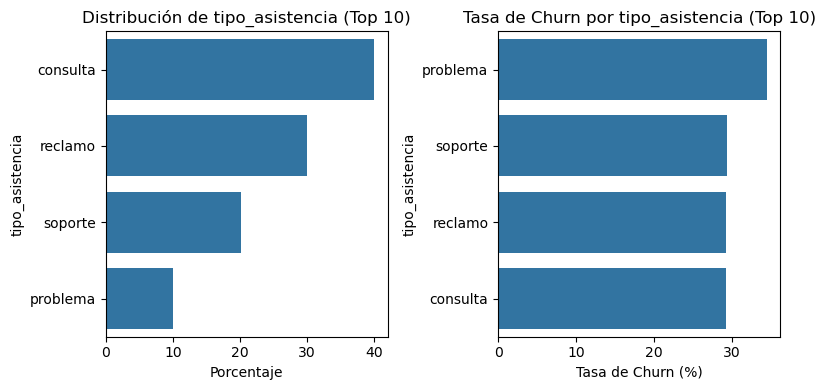

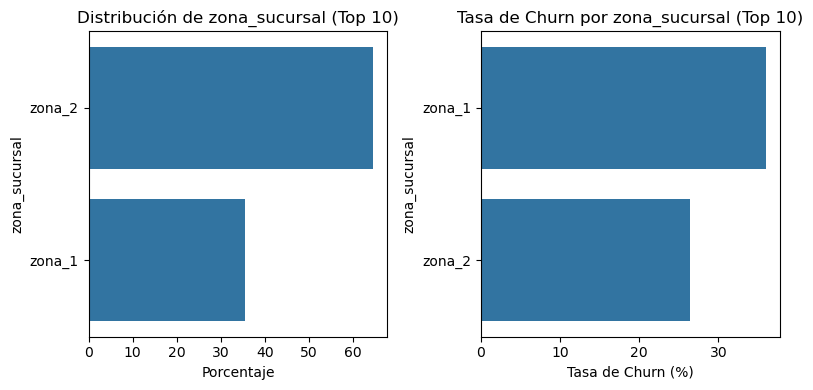

In [21]:
# Función para graficar variables categóricas vs churn
def plot_categorical_vs_churn(column, top_categories=10):
    plt.figure(figsize=(8, 4))
    
    # Distribución general
    plt.subplot(1, 2, 1)
    dist = df[column].value_counts(normalize=True)[:top_categories] * 100
    sns.barplot(y=dist.index, x=dist.values, orient='h')
    plt.title(f'Distribución de {column} (Top {top_categories})')
    plt.xlabel('Porcentaje')
    
    # Tasa de churn por categoría
    plt.subplot(1, 2, 2)
    churn_rate = df.groupby(column)['churn'].mean().sort_values(ascending=False)[:top_categories] * 100
    sns.barplot(y=churn_rate.index, x=churn_rate.values, orient='h')
    plt.title(f'Tasa de Churn por {column} (Top {top_categories})')
    plt.xlabel('Tasa de Churn (%)')
    
    plt.tight_layout()
    plt.show()

# Análisis para variables categóricas clave
plot_categorical_vs_churn('segmento_cliente')
plot_categorical_vs_churn('tipo_asistencia')
plot_categorical_vs_churn('zona_sucursal')

- Analisis por variables categoricas:
    - Distribución de categorías (frecuencia relativa)
    - Tasa de churn por categoría
- Hipótesis por variable:
    - Segmento_cliente: "Algunos segmentos tienen mayor propensión al abandono"
    - Tipo_asistencia: "Ciertos tipos de consultas/operaciones predicen mayor churn"
    - Zona_sucursal: "El churn varía geográficamente por condiciones locales"
- Interpretación:
    - Identificar categorías con churn >2x el promedio como focos de atención
    - Detecta patrones como: "Clientes premium abandonan menos" o "Reclamos tienen alto churn"

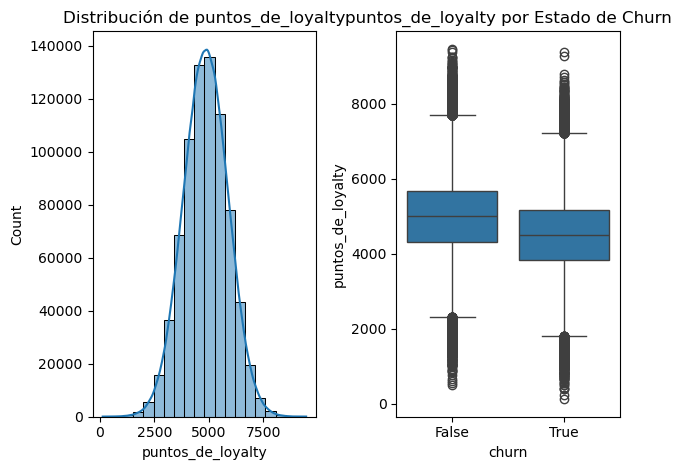

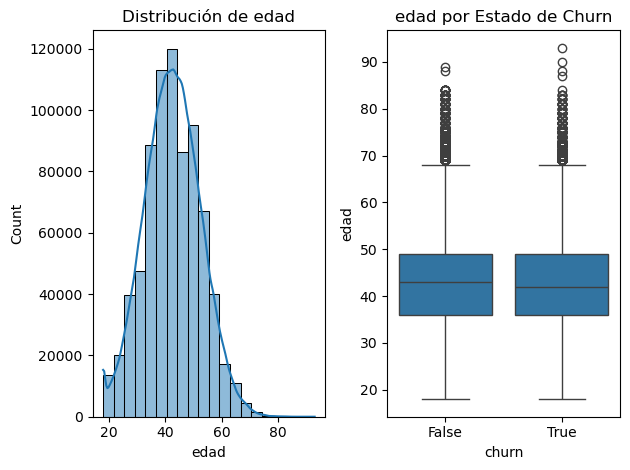

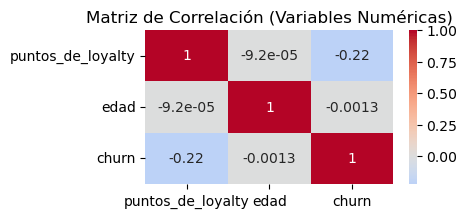

In [22]:
# Función para graficar variables numéricas
def plot_numeric_vs_churn(column, bins=20):
    
    # Distribución general
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=bins, kde=True)
    plt.title(f'Distribución de {column}')
    
    # Distribución por churn
    plt.subplot(1, 2, 2)
    sns.boxplot(x='churn', y=column, data=df)
    plt.title(f'{column} por Estado de Churn')
    
    plt.tight_layout()
    plt.show()

# Análisis para variables numéricas
plot_numeric_vs_churn('puntos_de_loyalty')
plot_numeric_vs_churn('edad')

# Correlación entre variables numéricas
numeric_cols = ['puntos_de_loyalty', 'edad', 'churn']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(4, 2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación (Variables Numéricas)')
plt.show()

- Análisis de Variables Numéricas (Edad, Puntos de Loyalty)
    - Distribución de valores
    - Relación con el churn
        - Hipótesis:
            - Edad: "Clientes más jóvenes tienen mayor movilidad bancaria"
            - Puntos_loyalty: "Menos puntos → menor engagement → mayor churn"
    - Interpretación:
            - Boxplots muestran diferencias en distribuciones entre churners y no churners

In [23]:
# Convertir fechas a datetime asegurando consistencia en zonas horarias
df['inicio_atencion_utc'] = pd.to_datetime(df['inicio_atencion_utc'], utc=True)
df['fin_atencion'] = pd.to_datetime(df['fin_atencion']).dt.tz_localize('America/Asuncion').dt.tz_convert('UTC')

# Extraer componentes temporales (sin zona horaria para facilitar análisis)
df['hora_atencion'] = df['inicio_atencion_utc'].dt.hour
df['dia_semana'] = df['inicio_atencion_utc'].dt.day_name()
df['mes'] = df['inicio_atencion_utc'].dt.month_name()

# Calcular duración de atención (en minutos)
df['duracion_atencion'] = (df['fin_atencion'] - df['inicio_atencion_utc']).dt.total_seconds() / 60

# Verificar resultados
print("Ejemplo de cálculo de duración:")
print(df[['inicio_atencion_utc', 'fin_atencion', 'duracion_atencion']].head())

Ejemplo de cálculo de duración:
        inicio_atencion_utc                        fin_atencion  \
0 2024-01-01 17:52:00+00:00 2024-01-01 18:08:39.861786534+00:00   
1 2024-01-01 13:00:00+00:00 2024-01-01 13:31:01.452232488+00:00   
2 2024-01-01 14:45:00+00:00 2024-01-01 15:17:10.491604314+00:00   
3 2024-01-01 18:58:00+00:00 2024-01-01 19:17:54.884666088+00:00   
4 2024-01-01 18:20:00+00:00 2024-01-01 18:36:38.272183704+00:00   

   duracion_atencion  
0          16.664363  
1          31.024204  
2          32.174860  
3          19.914744  
4          16.637870  


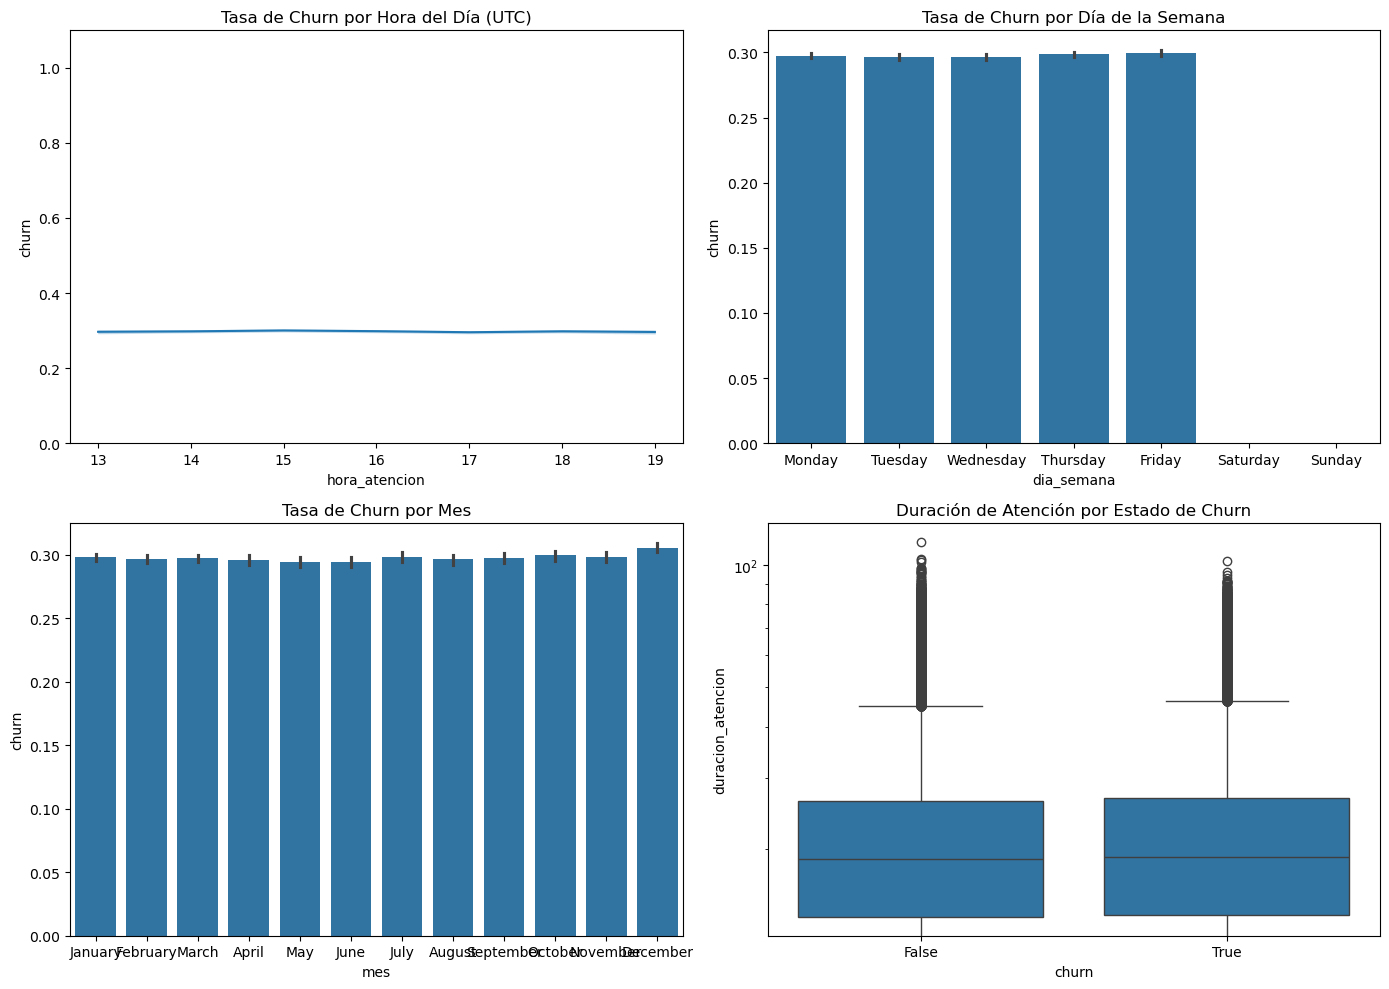

In [24]:
# Análisis temporal con los datos corregidos
plt.figure(figsize=(14, 10))

# 1. Churn por hora del día
plt.subplot(2, 2, 1)
sns.lineplot(x='hora_atencion', y='churn', data=df, estimator='mean')
plt.title('Tasa de Churn por Hora del Día (UTC)')
plt.ylim(0, df['churn'].max() * 1.1)

# 2. Churn por día de la semana
plt.subplot(2, 2, 2)
sns.barplot(x='dia_semana', y='churn', data=df, 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Tasa de Churn por Día de la Semana')

# 3. Churn por mes
plt.subplot(2, 2, 3)
sns.barplot(x='mes', y='churn', data=df, 
            order=['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Tasa de Churn por Mes')

# 4. Duración de atención vs churn
plt.subplot(2, 2, 4)
sns.boxplot(x='churn', y='duracion_atencion', data=df)
plt.title('Duración de Atención por Estado de Churn')
plt.yscale('log')  # Para manejar outliers

plt.tight_layout()
plt.show()

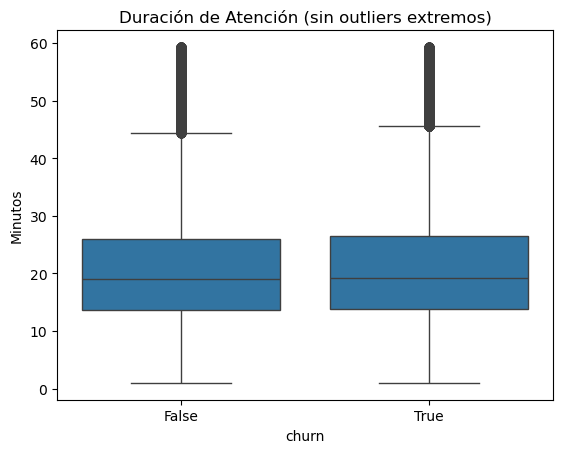

In [25]:
# Limpieza de valores extremos en duración
q_low = df['duracion_atencion'].quantile(0.01)
q_hi = df['duracion_atencion'].quantile(0.99)

df_clean = df[(df['duracion_atencion'] > q_low) & (df['duracion_atencion'] < q_hi)]

# Visualización sin outliers extremos
sns.boxplot(x='churn', y='duracion_atencion', data=df_clean)
plt.title('Duración de Atención (sin outliers extremos)')
plt.ylabel('Minutos')
plt.show()

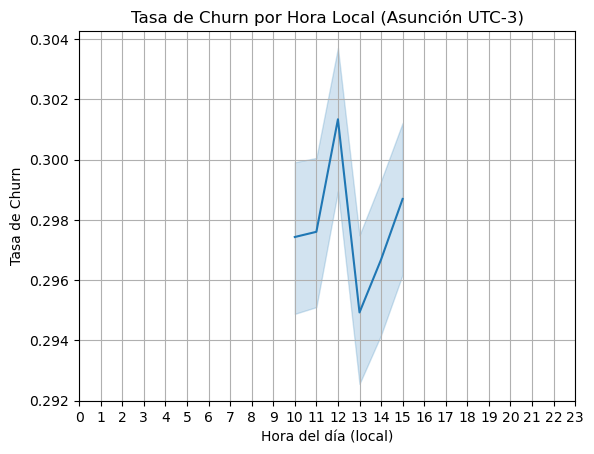

In [26]:
# Convertir a hora local de Paraguay (UTC-3) para análisis más relevante
df['hora_local'] = df['inicio_atencion_utc'].dt.tz_convert('America/Asuncion').dt.hour

# Tasa de churn por hora local

sns.lineplot(x='hora_local', y='churn', data=df, estimator='mean')
plt.title('Tasa de Churn por Hora Local (Asunción UTC-3)')
plt.xticks(range(24))
plt.xlabel('Hora del día (local)')
plt.ylabel('Tasa de Churn')
plt.grid(True)
plt.show()

- Análisis temporal:
    - Distribución por hora, día, mes y duración de atención
    - Tasa de churn según momento y duración de la interacción
- Hipótesis por variable:
    - Hora/Día: "Horarios fuera del laboral → mayor frustración → más churn"
    - Mes: "Patrones estacionales (ej. post-navidad)"
    - Duración: "Atenciones muy largas → insatisfacción → más churn"
- Interpretación:
    - Detectar picos de churn en franjas horarias específicas puede revelar problemas de capacidad
    - Duraciones superiores a X minutos pueden predecir insatisfacción y abandono
    - Analizar estacionalidad para anticipar aumentos de churn en ciertos meses

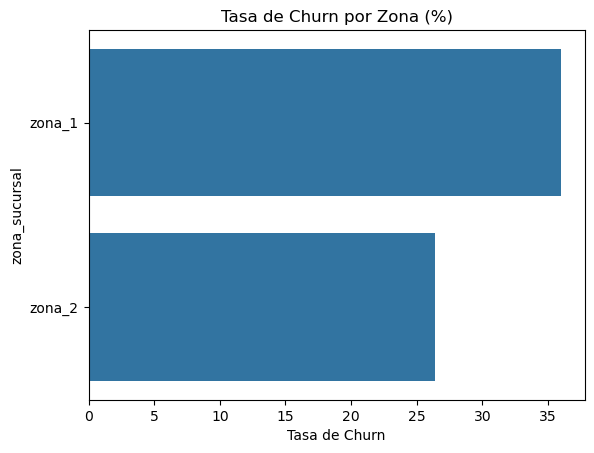

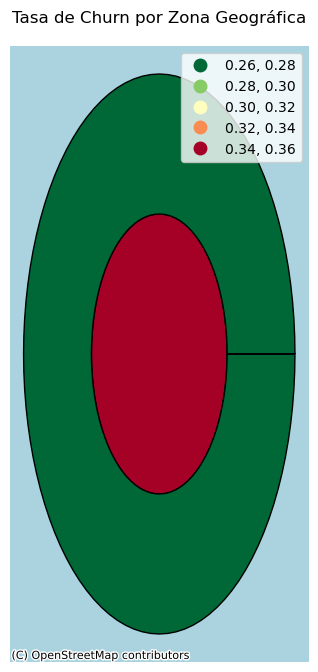

In [27]:
# Tasa de churn por zona
churn_by_zone = df.groupby('zona_sucursal')['churn'].mean().sort_values(ascending=False) * 100
sns.barplot(y=churn_by_zone.index, x=churn_by_zone.values, orient='h')
plt.title('Tasa de Churn por Zona (%)')
plt.xlabel('Tasa de Churn')
plt.show()

# Visualización geográfica
try:
    
    # Agregar churn rate a los polígonos
    gdf_zonas['churn_rate'] = gdf_zonas['zona'].map(df.groupby('zona_sucursal')['churn'].mean())
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf_zonas.plot(column='churn_rate', ax=ax, legend=True, 
                  cmap='RdYlGn_r', scheme='quantiles', edgecolor='black')
    ctx.add_basemap(ax, crs=gdf_zonas.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    plt.title('Tasa de Churn por Zona Geográfica')
    plt.axis('off')
    plt.show()
except ImportError:
    print("Para visualización geográfica, instale contextily: pip install contextily")

- Análisis Geográfico (Mapa de Calor por Zona)
      -Concentración geográfica del churn
- Hipótesis:
    - Zonas periféricas con menos sucursales tienen mayor churn
    - Factores socioeconómicos locales afectan retención
- Interpretación:
    - Identificar clusters geográficos problemáticos
    - Correlacionar con datos externos (nivel socioeconómico por zona)

In [28]:
zonas_por_cliente = df.groupby("cliente_id")["zona_sucursal"].nunique()

# Filtrar clientes que tienen más de una zona
clientes_multisucursal = zonas_por_cliente[zonas_por_cliente > 1]

# Mostrar resultados
print("Clientes con más de una sucursal:")
print(clientes_multisucursal)

Clientes con más de una sucursal:
Series([], Name: zona_sucursal, dtype: int64)


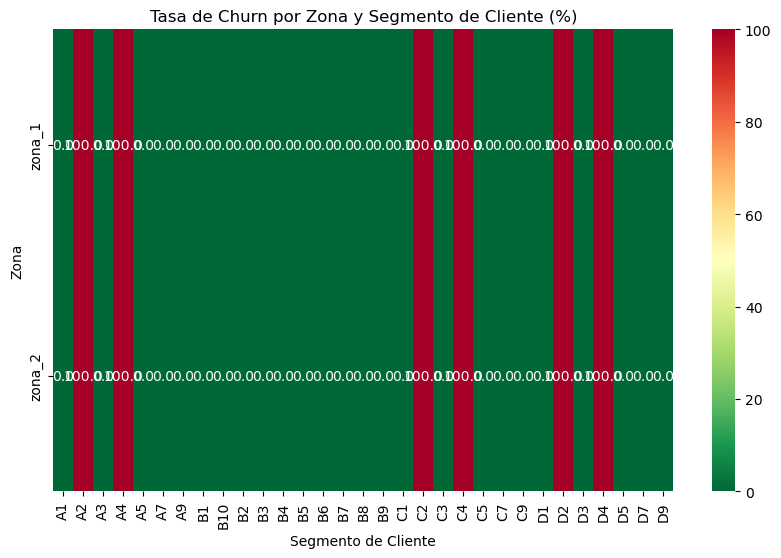

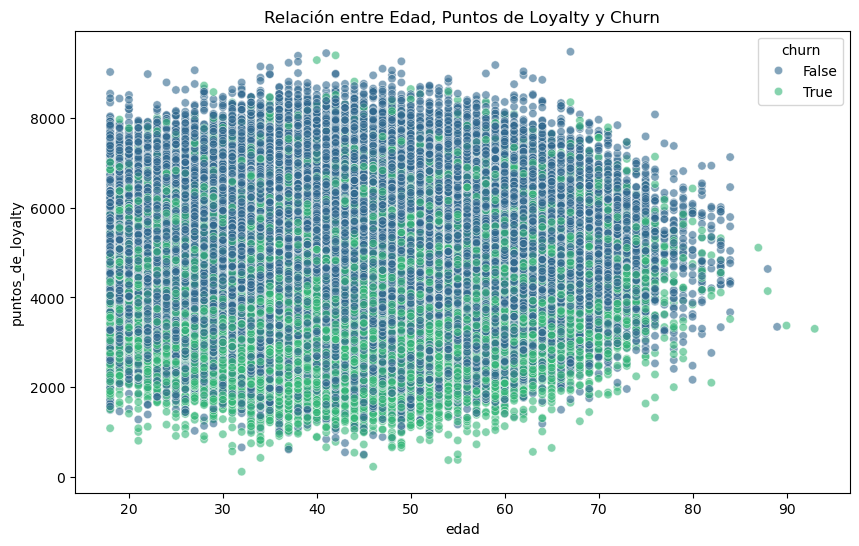

In [29]:
# Segmentación cruzada: zona vs segmento_cliente
cross_tab = pd.crosstab(df['zona_sucursal'], df['segmento_cliente'], 
                        values=df['churn'], aggfunc='mean') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='RdYlGn_r')
plt.title('Tasa de Churn por Zona y Segmento de Cliente (%)')
plt.ylabel('Zona')
plt.xlabel('Segmento de Cliente')
plt.show()

# Relación entre edad, puntos de loyalty y churn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='edad', y='puntos_de_loyalty', hue='churn', 
                data=df, alpha=0.6, palette='viridis')
plt.title('Relación entre Edad, Puntos de Loyalty y Churn')
plt.show()

- Análisis Multivariado (Segmentación Cruzada)
    - Qué representa:
        - Interacción entre variables clave
- Hipótesis:
    - El efecto del segmento varía según la zona
    - Clientes jóvenes en zona X son más propensos a abandonar

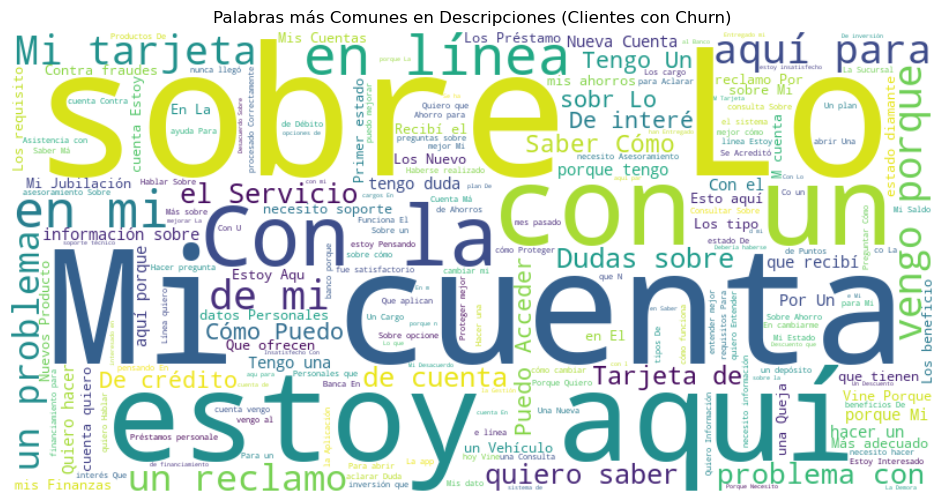

<Figure size 1000x600 with 0 Axes>

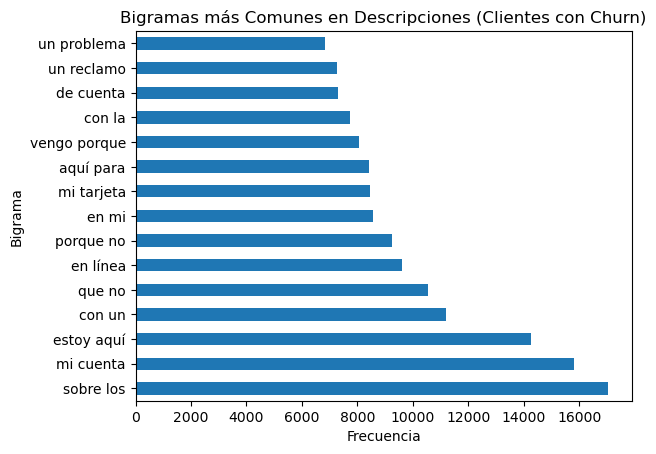

In [30]:
# Nube de palabras para churn=1
# Preprocesamiento de texto
text_data = df['descripcion_atencion'].dropna().astype(str)

text_churn = ' '.join(text_data[df['churn'] == 1])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_churn)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más Comunes en Descripciones (Clientes con Churn)')
plt.show()

# Análisis de bigramas
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20)
X = vectorizer.fit_transform(text_data[df['churn'] == 1])
bigrams = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out()).T.sort_values(0, ascending=False)

plt.figure(figsize=(10, 6))
bigrams[:15].plot(kind='barh', legend=False)
plt.title('Bigramas más Comunes en Descripciones (Clientes con Churn)')
plt.xlabel('Frecuencia')
plt.ylabel('Bigrama')
plt.show()

- Análisis de Texto
    - Términos más frecuentes en descripciones de clientes que abandonan
    - Ciertas palabras clave ('queja', 'error') predicen churn
    - Temas recurrentes indican problemas operativos específicos"
    - Términos como "tarjeta", "cargo", "servicio" señalan focos problemáticos
    - Bigramas frecuentes revelan procesos críticos ("no reconoce", "cobro múltiple")

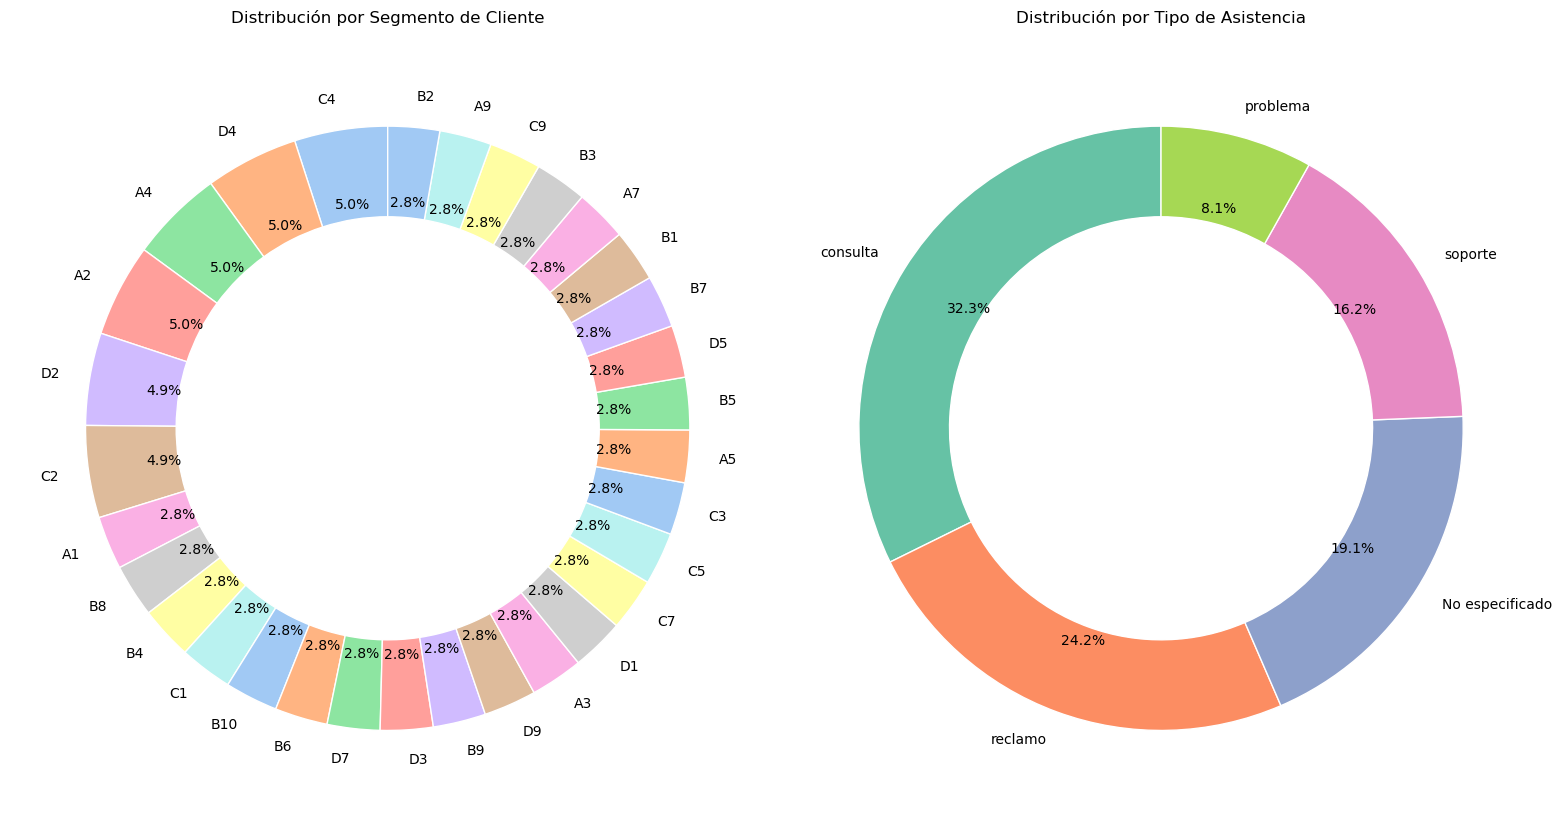

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

segmento_counts = df['segmento_cliente'].value_counts()
segmento_percent = segmento_counts / segmento_counts.sum() * 100

# Ordenar de mayor a menor
segmento_counts = segmento_counts.sort_values(ascending=False)

# Limpiar datos faltantes en tipo_asistencia
tipo_asistencia = df['tipo_asistencia'].fillna('No especificado')

# Calcular frecuencias
asistencia_counts = tipo_asistencia.value_counts()
asistencia_percent = asistencia_counts / asistencia_counts.sum() * 100

# Ordenar y limitar a top 5 + otros (si hay muchas categorías)
if len(asistencia_counts) > 5:
    top_5 = asistencia_counts.head(5)
    otros = asistencia_counts[5:].sum()
    asistencia_counts = pd.concat([top_5, pd.Series(otros, index=['Otros'])])
    asistencia_percent = asistencia_counts / asistencia_counts.sum() * 100

# Donut chart para segmento_cliente
segmento_counts.plot(
    kind='pie',
    ax=ax1,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel'),
    wedgeprops={'width': 0.3, 'linewidth': 1, 'edgecolor': 'white'},
    pctdistance=0.75,
    textprops={'fontsize': 10}
)
ax1.set_title('Distribución por Segmento de Cliente', pad=20)
ax1.set_ylabel('')

# Donut chart para tipo_asistencia
asistencia_counts.plot(
    kind='pie',
    ax=ax2,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Set2'),
    wedgeprops={'width': 0.3, 'linewidth': 1, 'edgecolor': 'white'},
    pctdistance=0.75,
    textprops={'fontsize': 10}
)
ax2.set_title('Distribución por Tipo de Asistencia', pad=20)
ax2.set_ylabel('')

# Añadir círculo central para efecto donut
for ax in [ax1, ax2]:
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax.add_artist(centre_circle)

plt.tight_layout()
plt.show()

Luego de este analisis, se comprobo que hay que un 17% de los datos que son nulos, ademas la distribucion de los segmentos de clientes, se puede reducir a solo: A,B,C y D.

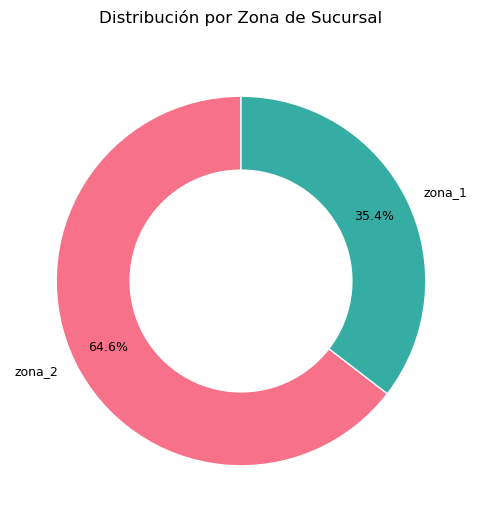

In [32]:
# Gráfico para zona_sucursal
plt.figure(figsize=(6, 6))
zona_counts = df['zona_sucursal'].value_counts()
zona_percent = zona_counts / zona_counts.sum() * 100

zona_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('husl', len(zona_counts)),
    wedgeprops={'width': 0.4, 'linewidth': 1, 'edgecolor': 'white'},
    pctdistance=0.8,
    textprops={'fontsize': 9}
)

plt.title('Distribución por Zona de Sucursal', pad=20)
plt.ylabel('')

# Efecto donut
centre_circle = plt.Circle((0,0), 0.60, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

In [33]:
#Reduccion del segmento de cliente de las categorias simple.
df1['segmento_cliente'] = df1['segmento_cliente'].str[0]
#Eliminacion de Nands, y reemplazo por categorias no espeficiados
df1['tipo_asistencia'] = df1['tipo_asistencia'].fillna('no_especificado')
df2 = df1.copy()

In [34]:
#from folium.plugins import MarkerCluster
#import folium
### 1. Asegurar que df sea un GeoDataFrame y esté en CRS 4326
#gdf = gpd.GeoDataFrame(df, geometry='geometry')
#gdf.set_crs(epsg=4326, inplace=True)

### 2. Crear mapa centrado en el centroide de todos los puntos
#centro = gdf.geometry.unary_union.centroid
#m = folium.Map(location=[centro.y, centro.x], zoom_start=12)

### 3. Crear un MarkerCluster
#cluster = MarkerCluster().add_to(m)

### 4. Añadir puntos con colores por churn
#for _, row in gdf.iterrows():
  #  color = 'green' if row['churn'] == 'No' else 'orange'
 #   tooltip = f"Cliente ID: {row['cliente_id']}<br>Zona: {row['zona_sucursal']}<br>Churn: {row['churn']}"
#    folium.CircleMarker(
 #       location=[row.geometry.y, row.geometry.x],
#        radius=5,
  #      color=color,
    #    fill=True,
   #     fill_opacity=0.8,
  #      tooltip=tooltip
 #   ).add_to(cluster)

### 5. Guardar o mostrar
#m.save("mapa_clientes_interactivo.html")"""

El codigo anterior, es para ver como impacta las zonas en un mapa interactivo, pero no se puede hacer, debido al tiempo de ejecucion<br>
Luego de hacer todo este analisis y tener difirentes conclusiones, se comienza con las limpienza de los mismos.

In [35]:
df1.head()

,cliente_id,segmento_cliente,tipo_asistencia,descripcion_atencion,inicio_atencion_utc,fin_atencion,puntos_de_loyalty,edad,churn,zona_sucursal,geometry
0,12462,C,soporte,Estoyaquí Para pedir ayudacon Un Error Tuerca ...,2024-01-01 17:52:00+00:00,2024-01-01 15:08:39.861786534,3149.471104,40,True,zona_1,POINT (-25.30126 -57.58451)
1,7471,B,soporte,vengo Porqu Necesito Asistencia Con Mi Tarjeta...,2024-01-01 13:00:00+00:00,2024-01-01 10:31:01.452232488,5327.590530,51,False,zona_1,POINT (-25.30168 -57.58457)
2,43237,D,problema,Estoy aquí Porque mi cuenta ha sido Bloqueada,2024-01-01 14:45:00+00:00,2024-01-01 12:17:10.491604314,3105.681258,47,False,zona_1,POINT (-25.30169 -57.58479)
3,25235,C,consulta,Estoy interesado e Saber Másobre losbeneficios...,2024-01-01 18:58:00+00:00,2024-01-01 16:17:54.884666088,3063.190862,33,False,zona_1,POINT (-25.30138 -57.58431)
4,68218,B,consulta,Necesito idea sobre cómo Cambiar Mis datos per...,2024-01-01 18:20:00+00:00,2024-01-01 15:36:38.272183704,6113.842796,47,False,zona_2,POINT (-25.30185 -57.58508)


In [36]:
# Agrupar datos por segmento_cliente y edad exacta
grupo = df1.groupby(['segmento_cliente', 'edad']).size().reset_index(name='conteo')

# Crear gráfico sunburst sin labels
fig = px.sunburst(grupo, path=['segmento_cliente', 'edad'], values='conteo')

# Quitar los labels visibles
fig.update_traces(textinfo='none')

# Título
fig.update_layout(title='Segmento de Cliente por Edad Exacta ')
fig.show()

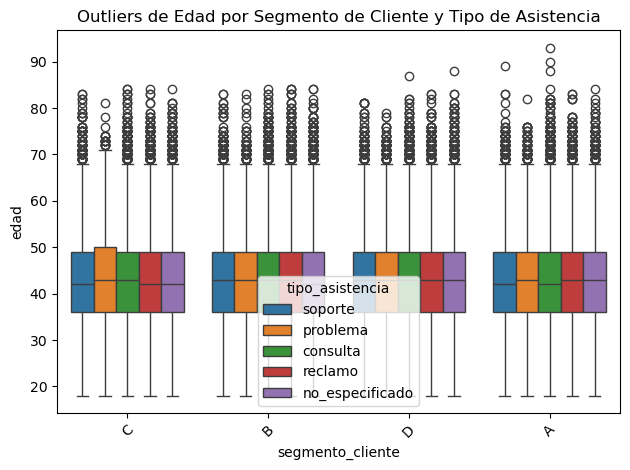

In [37]:
sns.boxplot(data=df1, x='segmento_cliente', y='edad', hue='tipo_asistencia')
plt.title('Outliers de Edad por Segmento de Cliente y Tipo de Asistencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

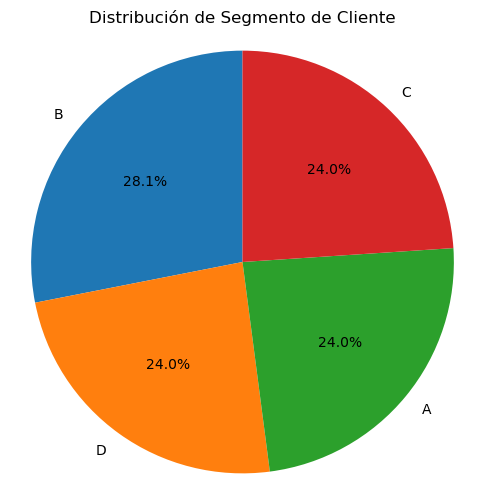

In [38]:
# Conteo de segmentos de cliente
segment_counts = df1['segmento_cliente'].value_counts()

# Gráfico de torta
plt.figure(figsize=(6,6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Segmento de Cliente')
plt.axis('equal')
plt.show()

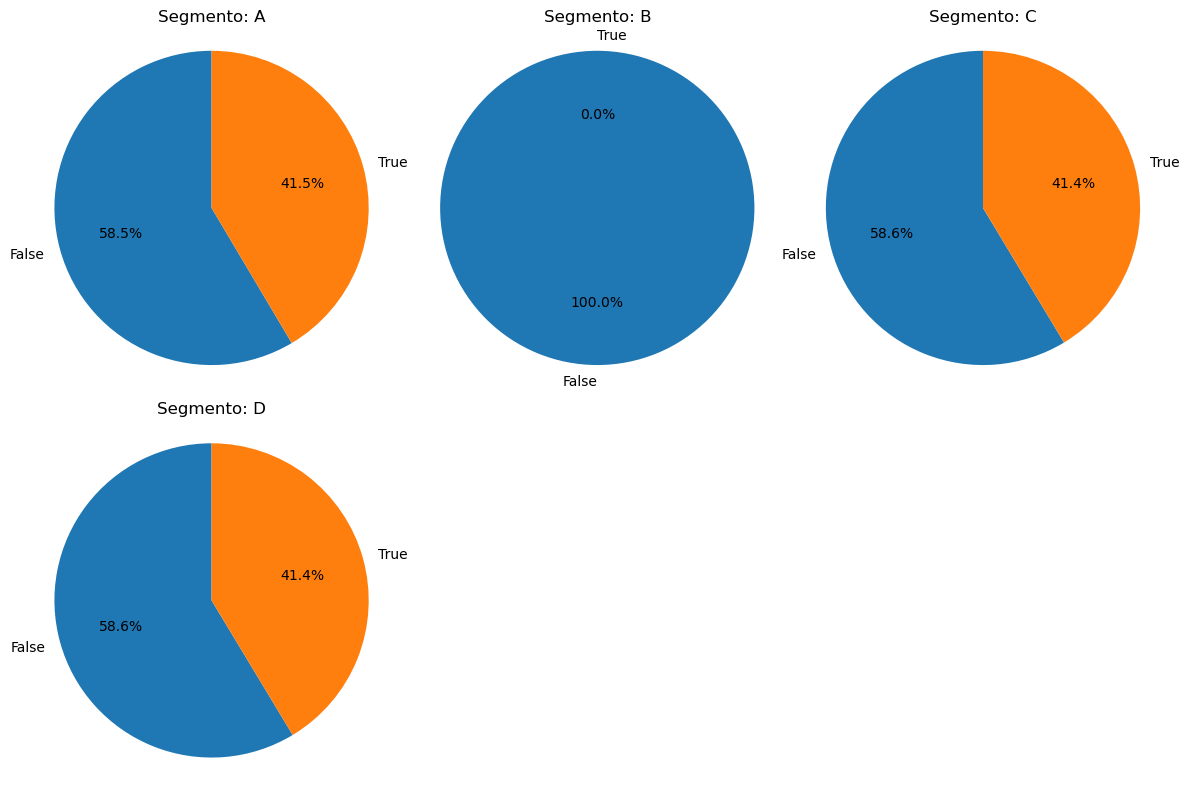

In [39]:
# Agrupar datos
churn_counts = df1.groupby(['segmento_cliente', 'churn']).size().unstack(fill_value=0)

# Número de segmentos
segmentos = churn_counts.index
n_segmentos = len(segmentos)

# Calcular layout de subplots
n_cols = min(n_segmentos, 3)  # máximo 3 columnas por fila
n_rows = (n_segmentos + n_cols - 1) // n_cols  # filas necesarias

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten() if n_segmentos > 1 else [axes]  # asegurar iterabilidad

# Dibujar cada gráfico de torta
for i, segmento in enumerate(segmentos):
    ax = axes[i]
    ax.pie(churn_counts.loc[segmento], labels=churn_counts.columns, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Segmento: {segmento}')
    ax.axis('equal')  # círculo perfecto

# Ocultar ejes no usados (si los hay)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

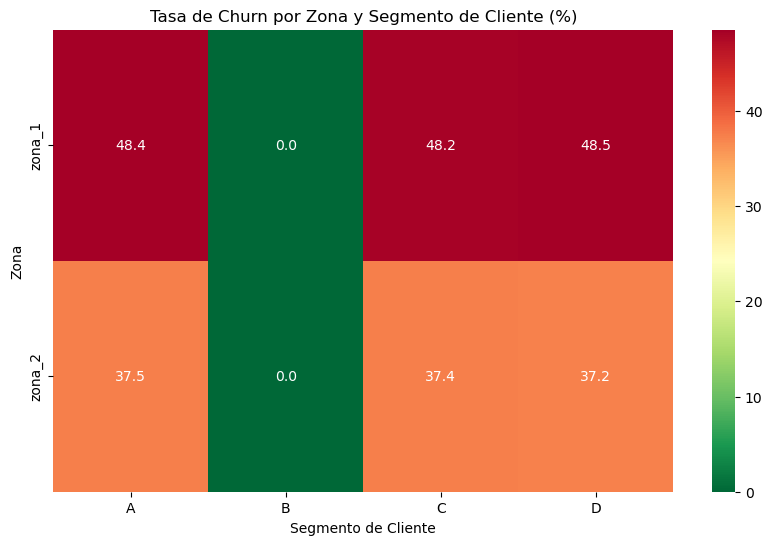

In [40]:
# Segmentación cruzada: zona vs segmento_cliente
cross_tab = pd.crosstab(df1['zona_sucursal'], df1['segmento_cliente'], 
                        values=df1['churn'], aggfunc='mean') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='RdYlGn_r')
plt.title('Tasa de Churn por Zona y Segmento de Cliente (%)')
plt.ylabel('Zona')
plt.xlabel('Segmento de Cliente')
plt.show()

In [41]:
# Conteo cruzado
zona_counts = df1.groupby(['segmento_cliente', 'zona_sucursal']).size().reset_index(name='conteo')

# Gráfico sunburst
fig = px.sunburst(zona_counts, path=['segmento_cliente', 'zona_sucursal'], values='conteo',
                  title='Segmento de Cliente por Zona de Sucursal')
fig.show()

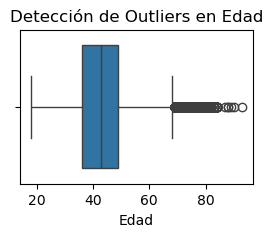

In [42]:
plt.figure(figsize=(3, 2))
sns.boxplot(x=df1['edad'])
plt.title('Detección de Outliers en Edad')
plt.xlabel('Edad')
plt.show()

In [43]:
# Cálculo del IQR
Q1 = df1['edad'].quantile(0.25)
Q3 = df1['edad'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar outliers
outliers = df1[(df1['edad'] < limite_inferior) | (df1['edad'] > limite_superior)]

print(f"Cantidad de outliers detectados: {len(outliers)}")
display(outliers[['cliente_id', 'edad']])

Cantidad de outliers detectados: 3722


,cliente_id,edad
1135,41369,70
1445,1669,69
2265,4885,69
2478,25874,76
2499,98108,69
...,...,...
765536,191107,71
765545,322957,75
765608,205107,75
765634,275201,69


In [44]:
# Eliminar outliers
df1 = df1[(df1['edad'] >= limite_inferior) & (df1['edad'] <= limite_superior)]

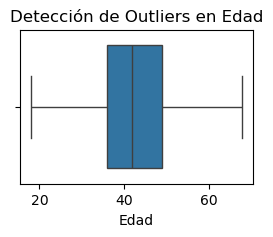

In [45]:
plt.figure(figsize=(3, 2))
sns.boxplot(x=df1['edad'])
plt.title('Detección de Outliers en Edad')
plt.xlabel('Edad')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



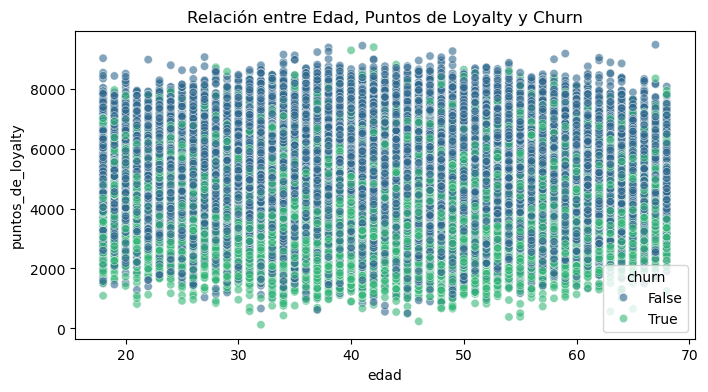

In [46]:
# Relación entre edad, puntos de loyalty y churn
plt.figure(figsize=(8, 4))
sns.scatterplot(x='edad', y='puntos_de_loyalty', hue='churn', 
                data=df1, alpha=0.6, palette='viridis')
plt.title('Relación entre Edad, Puntos de Loyalty y Churn')
plt.show()

<b>Nota</b>: Se aplicará una eliminación de outliers basada en la edad, ya que resulta necesaria para el análisis. Sin embargo, debido a la falta de datos demográficos que indiquen la edad máxima esperada dentro del conjunto, esta limpieza no podrá realizarse con la precisión deseada.

<b>Nota</b>: Previo a hacer el tema de esta variable, se noto un problema, que hay un problema dentro del dataset, con respecto a la los datos, de fin_atencion corresponde a atencion inicial y inicio corresponde a atencion final.

In [47]:
df3 = df1.copy()
# Asegurar que las columnas estén en formato datetime
df3['inicio_atencion_utc'] = pd.to_datetime(df1['inicio_atencion_utc']).dt.tz_localize(None)
df3['fin_atencion'] = pd.to_datetime(df1['fin_atencion']).dt.tz_localize(None)

# Calcular el tiempo de atención
df3['tiempo_atencion'] = df3['inicio_atencion_utc'] - df3['fin_atencion']
df3['tiempo_atencion'] = df3['tiempo_atencion'].dt.total_seconds() / 60
df3.head()

,cliente_id,segmento_cliente,tipo_asistencia,descripcion_atencion,inicio_atencion_utc,fin_atencion,puntos_de_loyalty,edad,churn,zona_sucursal,geometry,tiempo_atencion
0,12462,C,soporte,Estoyaquí Para pedir ayudacon Un Error Tuerca ...,2024-01-01 17:52:00,2024-01-01 15:08:39.861786534,3149.471104,40,True,zona_1,POINT (-25.30126 -57.58451),163.335637
1,7471,B,soporte,vengo Porqu Necesito Asistencia Con Mi Tarjeta...,2024-01-01 13:00:00,2024-01-01 10:31:01.452232488,5327.590530,51,False,zona_1,POINT (-25.30168 -57.58457),148.975796
2,43237,D,problema,Estoy aquí Porque mi cuenta ha sido Bloqueada,2024-01-01 14:45:00,2024-01-01 12:17:10.491604314,3105.681258,47,False,zona_1,POINT (-25.30169 -57.58479),147.825140
3,25235,C,consulta,Estoy interesado e Saber Másobre losbeneficios...,2024-01-01 18:58:00,2024-01-01 16:17:54.884666088,3063.190862,33,False,zona_1,POINT (-25.30138 -57.58431),160.085256
4,68218,B,consulta,Necesito idea sobre cómo Cambiar Mis datos per...,2024-01-01 18:20:00,2024-01-01 15:36:38.272183704,6113.842796,47,False,zona_2,POINT (-25.30185 -57.58508),163.362130


In [48]:
df3.describe(include="all")

,cliente_id,segmento_cliente,tipo_asistencia,descripcion_atencion,inicio_atencion_utc,fin_atencion,puntos_de_loyalty,edad,churn,zona_sucursal,geometry,tiempo_atencion
count,762009.000000,762009,762009,762009,762009,762009,762009.000000,762009.000000,762009,762009,762009,762009.000000
unique,NaN,4,5,728571,NaN,NaN,NaN,NaN,2,2,35,NaN
top,NaN,B,consulta,Necesito Asesoramiento Sobre Ahorro para Mi ju...,NaN,NaN,NaN,NaN,False,zona_2,POINT (-25.301464636374526 -57.58443665121567),NaN
freq,NaN,213983,246132,27,NaN,NaN,NaN,NaN,535077,491832,27341,NaN
mean,133550.253186,NaN,NaN,NaN,2024-08-15 11:24:19.173159168,2024-08-15 08:18:29.672235264,4851.180559,42.411559,NaN,NaN,NaN,185.825015
min,1.000000,NaN,NaN,NaN,2024-01-01 13:00:00,2024-01-01 10:08:44.754428730,123.473670,18.000000,NaN,NaN,NaN,77.093001
25%,63563.000000,NaN,NaN,NaN,2024-04-24 18:32:00,2024-04-24 14:53:44.435778048,4159.565265,36.000000,NaN,NaN,NaN,159.885050
50%,127345.000000,NaN,NaN,NaN,2024-08-14 16:07:00,2024-08-14 12:26:44.236251392,4853.571849,42.000000,NaN,NaN,NaN,170.754812
75%,197936.000000,NaN,NaN,NaN,2024-12-06 14:15:00,2024-12-06 11:35:48.404685824,5544.857221,49.000000,NaN,NaN,NaN,219.590586
max,327236.000000,NaN,NaN,NaN,2025-03-31 19:59:00,2025-03-31 16:45:04.619943126,9464.957703,68.000000,NaN,NaN,NaN,240.000000


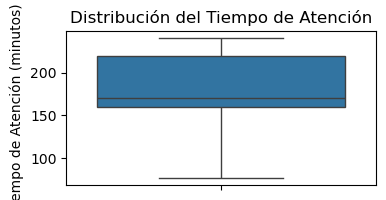

In [49]:
# Crear el boxplot
plt.figure(figsize=(4, 2))
sns.boxplot(y=df3['tiempo_atencion'])
plt.title('Distribución del Tiempo de Atención')
plt.ylabel('Tiempo de Atención (minutos)')
plt.xlabel('')

plt.show()

<b>Nota:</b> 
Se vio la posibilidad de añadir varias variables nuevas:
- <b>intensidad_loyalty:</b> como la relacion entre los puntos y la edad, no tiene buena relacion entre si las variables.
- <b>La distancia a la sucursal:</b> No se ve muy importante y que valla a tener impacto en el mismo. 
- <b>frecuencia_tipo_asistencia:</b> Número de veces que el cliente ha recibido cierto tipo de asistencia en un período dado (requiere histórico)<br>
Ademas si se querian crear nuevas variables y analizar bien el churn, los clientes lo maximo que llegaban a consulta repetidas eran 16, en el periodo de un año, esto para la creacion de un algortimo de churn, tomando en cuenta la parte historica, no servia. Ya que el 5 % independientemente de la condicion (churn), tenia mas de 2 consultas. 

### Modelado de datos

In [50]:
def predecir_churn(tipo_asistencia):
    tipo_asistencia = str(tipo_asistencia)
    if tipo_asistencia.lower() == 'problema':
        return 1.0  # Siempre devuelve 1 si es un problema
    elif tipo_asistencia.lower() == 'reclamo':
        return 0.8 if random.random() < 0.5 else 0  # 50% de probabilidad para reclamos
    else:
        return 0


def preprocess_data(df3):
    # Crear una copia del DataFrame para trabajar sobre ella
    df4 = df3.copy()

    # Extraer longitud de la descripción
    df4['longitud_descripcion'] = df4['descripcion_atencion'].str.len()

    # Simplificar zonas 
    df4['zona_sucursal'] = df4['zona_sucursal'].apply(lambda x: 0 if x == 'zona 1' else 1)

    # Predecir churn
    df4['prob_churn'] = df4['tipo_asistencia'].apply(predecir_churn)

    # Eliminar columnas no necesarias si existen
    columnas_a_eliminar = ['cliente_id', 'inicio_atencion_utc', 'fin_atencion', 'geometry', 'descripcion_atencion']
    columnas_existentes = [col for col in columnas_a_eliminar if col in df4.columns]
    df4 = df4.drop(columnas_existentes, axis=1)
    return df4

#Nota:
# Zona 1 = 0 y Zona 2= 1


# Aplicar función
df_clean = preprocess_data(df3)
df_clean.head()

,segmento_cliente,tipo_asistencia,puntos_de_loyalty,edad,churn,zona_sucursal,tiempo_atencion,longitud_descripcion,prob_churn
0,C,soporte,3149.471104,40,True,1,163.335637,56,0.0
1,B,soporte,5327.590530,51,False,1,148.975796,58,0.0
2,D,problema,3105.681258,47,False,1,147.825140,45,1.0
3,C,consulta,3063.190862,33,False,1,160.085256,69,0.0
4,B,consulta,6113.842796,47,False,1,163.362130,54,0.0


In [51]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762009 entries, 0 to 765730
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   segmento_cliente      762009 non-null  object 
 1   tipo_asistencia       762009 non-null  object 
 2   puntos_de_loyalty     762009 non-null  float64
 3   edad                  762009 non-null  int64  
 4   churn                 762009 non-null  bool   
 5   zona_sucursal         762009 non-null  int64  
 6   tiempo_atencion       762009 non-null  float64
 7   longitud_descripcion  762009 non-null  int64  
 8   prob_churn            762009 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(2)
memory usage: 53.0+ MB


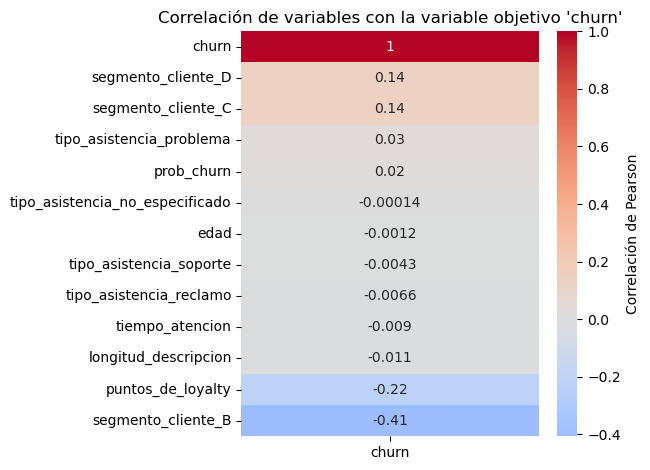

In [52]:
# 1. Convertir variables categóricas
df_dummies = pd.get_dummies(df_clean, columns=['segmento_cliente', 'tipo_asistencia', 'zona_sucursal'], drop_first=True)

# 2. Calcular la matriz de correlación de Pearson
correlacion_pearson = df_dummies.corr(method='pearson')

# 3. Extraer las correlaciones con la variable target 'churn'
correlaciones_churn = correlacion_pearson['churn'].sort_values(ascending=False)

# 4. Graficar las correlaciones con 'churn'
sns.heatmap(correlaciones_churn.to_frame(), annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlación de Pearson'})
plt.title("Correlación de variables con la variable objetivo 'churn'")
plt.tight_layout()
plt.show()

### Etapa de Entrenamiento

In [53]:
# Separar en train y test
X = df_clean.drop('churn', axis=1)
y = df_clean['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [54]:
# Asegurar división adecuada
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, X Shape:{X.shape}, y shape:{y.shape}, y test shape:{y_test.shape}")
print(f"Proporción churn en train: {y_train.mean():.2f}")
print(f"Proporción churn en test: {y_test.mean():.2f}")

Train shape: (533406, 8), Test shape: (228603, 8), X Shape:(762009, 8), y shape:(762009,), y test shape:(228603,)
Proporción churn en train: 0.30
Proporción churn en test: 0.30


In [55]:
# Definir transformaciones
numeric_features = ['puntos_de_loyalty', 'edad','zona_sucursal','longitud_descripcion','prob_churn','tiempo_atencion']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['segmento_cliente', 'tipo_asistencia', ]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Modelado de datos

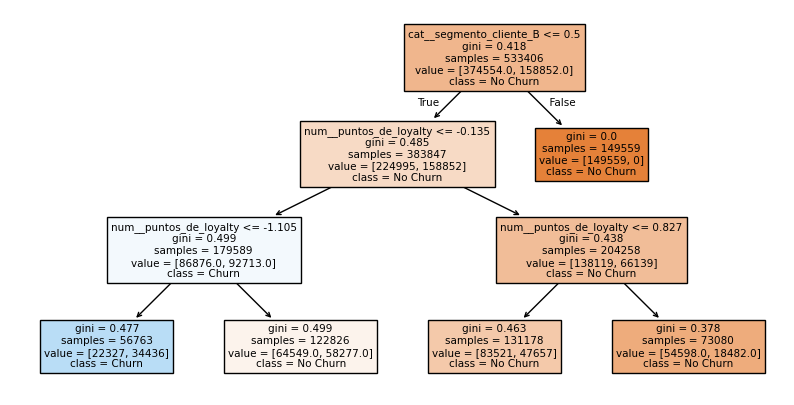

In [56]:
# Modelo simple para diagnóstico
simple_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=3))
])

simple_model.fit(X_train, y_train)

# Visualización del árbol
plt.figure(figsize=(10,5))
plot_tree(simple_model.named_steps['classifier'], 
          feature_names=simple_model.named_steps['preprocessor'].get_feature_names_out(),
          class_names=['No Churn','Churn'],
          filled=True)
plt.show()

In [57]:
# Verificar transformaciones
X_transformed = pd.DataFrame(preprocessor.transform(X_train))
print("\nPrimeras filas transformadas:")
print(X_transformed.head())

# Verificar si hay columnas transformadas con valores infinitos
print("\nValores infinitos en datos transformados:")
print(np.isinf(X_transformed.values).sum())


Primeras filas transformadas:
         0         1    2         3         4         5    6    7    8    9   \
0 -1.202557 -0.042755  0.0  1.528858 -0.499634  1.036884  1.0  0.0  0.0  0.0   
1 -0.336203  1.903109  0.0 -0.267541  1.745245  1.162729  0.0  0.0  1.0  0.0   
2  0.549750 -0.554824  0.0  4.276291 -0.499634 -0.706889  0.0  1.0  0.0  0.0   
3 -0.215094 -1.374135  0.0  0.472153 -0.499634 -1.257436  0.0  0.0  1.0  0.0   
4  0.147012  0.981384  0.0 -0.901564 -0.499634  1.406357  0.0  1.0  0.0  0.0   

    10   11   12   13   14  
0  0.0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  1.0  0.0  
2  1.0  0.0  0.0  0.0  0.0  
3  0.0  1.0  0.0  0.0  0.0  
4  1.0  0.0  0.0  0.0  0.0  

Valores infinitos en datos transformados:
0


<b>Nota:</b> Aca se ve como es la performance del modelo y lo que puede afectar, ademas de verificar que no me 100% los datos, y luego realizo una verificacion de la transformacion

In [58]:
#Definicion de Modelos
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]),
    
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(eval_metric='logloss', random_state=42))
    ])
}

In [59]:
# Función para evaluar modelos
def evaluate_model(model, X_train, y_train, X_test, y_test, plot_roc=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'pr_auc': average_precision_score(y_test, y_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'fpr': None,
        'tpr': None
    }
    
    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr
    
    if plot_roc:
        plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {metrics["roc_auc"]:.2f})')
    
    return metrics


Evaluando Logistic Regression...

Resultados para Logistic Regression:
Accuracy: 0.729
Precision: 0.578
Recall: 0.329
F1-Score: 0.420
ROC AUC: 0.784
PR AUC: 0.547

Matriz de Confusión:
[[144164  16359]
 [ 45664  22416]]

Evaluando Random Forest...

Resultados para Random Forest:
Accuracy: 0.707
Precision: 0.512
Recall: 0.368
F1-Score: 0.429
ROC AUC: 0.757
PR AUC: 0.497

Matriz de Confusión:
[[136608  23915]
 [ 42995  25085]]

Evaluando Gradient Boosting...

Resultados para Gradient Boosting:
Accuracy: 0.729
Precision: 0.577
Recall: 0.334
F1-Score: 0.423
ROC AUC: 0.784
PR AUC: 0.546

Matriz de Confusión:
[[143810  16713]
 [ 45312  22768]]

Evaluando XGBoost...

Resultados para XGBoost:
Accuracy: 0.726
Precision: 0.572
Recall: 0.324
F1-Score: 0.414
ROC AUC: 0.782
PR AUC: 0.540

Matriz de Confusión:
[[143996  16527]
 [ 46023  22057]]


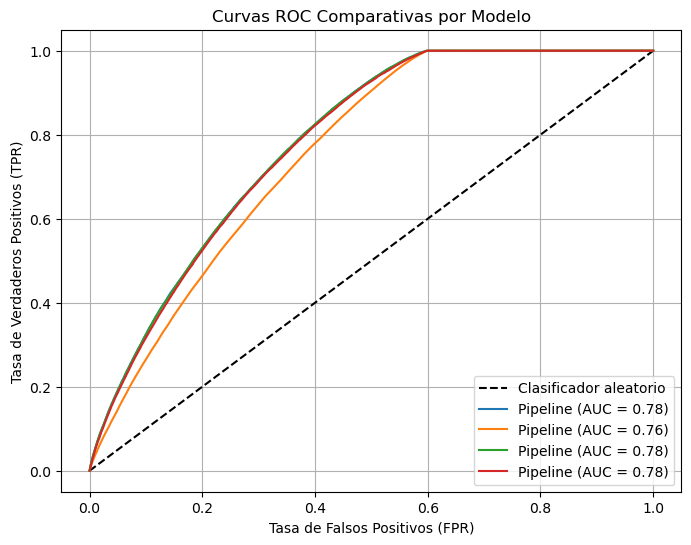

In [60]:
# Configurar gráfico ROC
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')

# Entrenamiento y evaluación
results = {}
for name, model in models.items():
    print(f"\nEvaluando {name}...")
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, plot_roc=True)
    results[name] = metrics
    
    print(f"\nResultados para {name}:")
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Recall: {metrics['recall']:.3f}")
    print(f"F1-Score: {metrics['f1']:.3f}")
    print(f"ROC AUC: {metrics['roc_auc']:.3f}")
    print(f"PR AUC: {metrics['pr_auc']:.3f}")
    print("\nMatriz de Confusión:")
    print(metrics['confusion_matrix'])

# Configuraciones finales del gráfico ROC
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Comparativas por Modelo')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [61]:
# Selección del mejor modelo
best_model_name = max(results, key=lambda k: results[k]['f1'])
best_model = models[best_model_name]
best_metrics = results[best_model_name]

print(f"\nMEJOR MODELO: {best_model_name}")
print(f"F1-Score: {best_metrics['f1']:.3f}")
print(f"ROC AUC: {best_metrics['roc_auc']:.3f}")
print(f"Precision: {best_metrics['precision']:.3f}")
print(f"Recall: {best_metrics['recall']:.3f}")
print(f"F1-Score: {metrics['f1']:.3f}")
print(f"ROC AUC: {metrics['roc_auc']:.3f}")
print(f"PR AUC: {metrics['pr_auc']:.3f}")


MEJOR MODELO: Random Forest
F1-Score: 0.429
ROC AUC: 0.757
Precision: 0.512
Recall: 0.368
F1-Score: 0.414
ROC AUC: 0.782
PR AUC: 0.540


<b>Nota:</b> Se decidio elegir el F1, porque es la principal metrica que se toma cuando es un modelo de churn.
- Refleja mejor el impacto económico que el accuracy (que ignora costos asimétricos).


In [62]:
# Optimización para Random Forest
#if best_model_name == 'Random Forest':
#    param_grid = {
#        'classifier__n_estimators': [100, 200, 300],
#        'classifier__max_depth': [None, 10, 20],
#        'classifier__min_samples_split': [2, 5, 10],
#        'classifier__max_features': ['sqrt', 'log2']
#    }
    
#    grid_search = GridSearchCV(
#        best_model,
#        param_grid,
#        cv=5,
#        scoring='f1',
#        n_jobs=-1,
#        verbose=1
#    )
    
#    print("\nOptimizando Random Forest...")
#    grid_search.fit(X_train, y_train)
    
#    best_model = grid_search.best_estimator_
#    print(f"\nMejores parámetros: {grid_search.best_params_}")
    
    # Evaluación final
#    final_metrics = evaluate_model(best_model, X_train, y_train, X_test, y_test)
#    print("\nResultados finales optimizados:")
#    print(f"F1-Score: {final_metrics['f1']:.3f}")
#    print(f"ROC AUC: {final_metrics['roc_auc']:.3f}")

In [63]:
# Definir transformaciones
numeric_features = ['puntos_de_loyalty', 'edad','zona_sucursal','longitud_descripcion','prob_churn','tiempo_atencion']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['segmento_cliente', 'tipo_asistencia', ]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Mejor modelo es Randomforest
if best_model_name == 'Random Forest':
    # Muestreo de datos 
    X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=150000, random_state=42, stratify=y_train)
    
    # Espacio de hiperparámetros reducido
    param_dist = {
        'classifier__n_estimators': randint(100, 300), 
        'classifier__max_depth': [None, 10, 20],       
        'classifier__min_samples_split': randint(2, 10),
        'classifier__max_features': ['sqrt', 'log2']
    }
    
    # K-Fold con 3 particiones
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    random_search = RandomizedSearchCV(
        best_model,
        param_distributions=param_dist,
        n_iter=20,   
        cv=kf,      
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    print("\nOptimizando Random Forest con RandomizedSearchCV ")
    random_search.fit(X_train_sample, y_train_sample)
    
    best_model = random_search.best_estimator_
    print(f"\nMejores parámetros: {random_search.best_params_}")
    
    # Entrenar modelo final con todos los datos
    print("\nEntrenando modelo final con todos los datos...")
    best_model.fit(X_train, y_train)
    
    # Evaluación final
    final_metrics = evaluate_model(best_model, X_train, y_train, X_test, y_test)
    print("\nResultados finales optimizados:")
    print(f"F1-Score: {final_metrics['f1']:.3f}")
    print(f"ROC AUC: {final_metrics['roc_auc']:.3f}")


Optimizando Random Forest con RandomizedSearchCV 
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 4, 'classifier__n_estimators': 269}

Entrenando modelo final con todos los datos...

Resultados finales optimizados:
F1-Score: 0.434
ROC AUC: 0.761


<b>Nota</b> Se hizo con una poblacion aleatoria de 150K ya que si era mayor, era mas tiempo de desarrollo

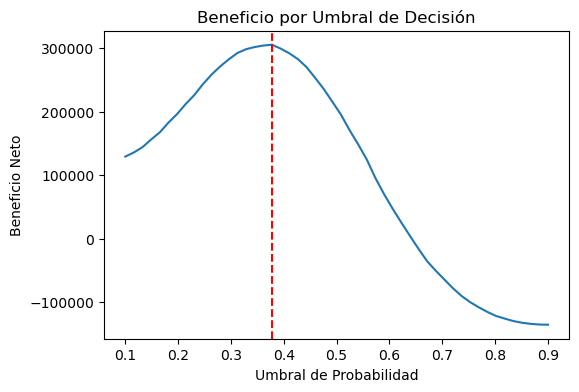


Umbral óptimo: 0.38
Beneficio máximo: 305480.00

Métricas con umbral óptimo:
              precision    recall  f1-score   support

       False       0.83      0.69      0.75    160523
        True       0.47      0.66      0.55     68080

    accuracy                           0.68    228603
   macro avg       0.65      0.68      0.65    228603
weighted avg       0.72      0.68      0.69    228603


Matriz de Confusión:
[[110381  50142]
 [ 22940  45140]]

Beneficio esperado: 305480.00


In [64]:
# Función de beneficio actualizada
def calcular_beneficio_actualizado(cm):
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    
    beneficio = (tp * (rentabilidad_largo - costo_retencion) + 
                fp * (-costo_retencion) + 
                fn * rentabilidad_baja)
    
    return beneficio

# Búsqueda de umbral óptimo
y_proba = best_model.predict_proba(X_test)[:,1]
thresholds = np.linspace(0.1, 0.9, 50)
beneficios = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    beneficios.append(calcular_beneficio_actualizado(cm))

optimal_idx = np.argmax(beneficios)
optimal_threshold = thresholds[optimal_idx]
max_beneficio = beneficios[optimal_idx]

# Gráfico
plt.figure(figsize=(6,4))
plt.plot(thresholds, beneficios)
plt.axvline(optimal_threshold, color='r', linestyle='--')
plt.title('Beneficio por Umbral de Decisión')
plt.xlabel('Umbral de Probabilidad')
plt.ylabel('Beneficio Neto')
plt.show()

print(f"\nUmbral óptimo: {optimal_threshold:.2f}")
print(f"Beneficio máximo: {max_beneficio:.2f}")

# Evaluación con umbral óptimo
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
optimal_cm = confusion_matrix(y_test, y_pred_optimal)

print("\nMétricas con umbral óptimo:")
print(classification_report(y_test, y_pred_optimal))
print("\nMatriz de Confusión:")
print(optimal_cm)
print(f"\nBeneficio esperado: {calcular_beneficio_actualizado(optimal_cm):.2f}")

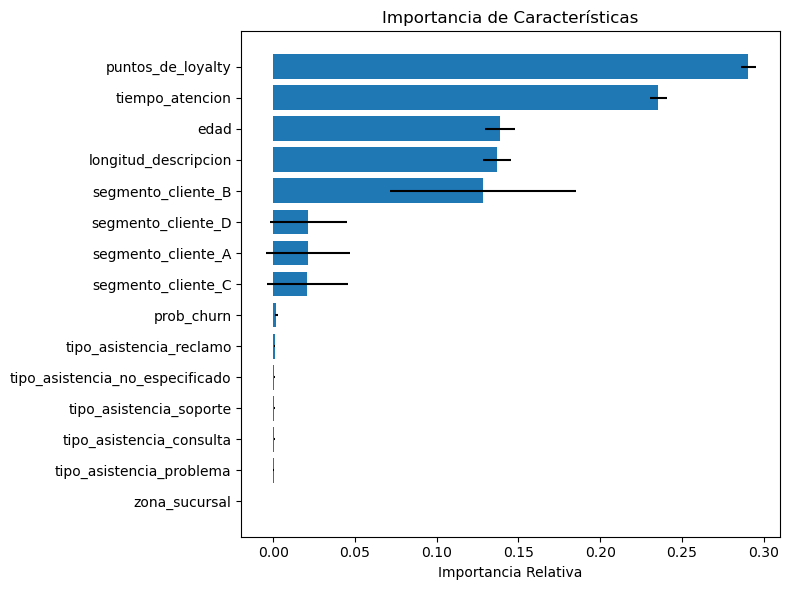


Top 10 características más importantes:
                    feature  importance       std
0         puntos_de_loyalty    0.290721  0.004333
5           tiempo_atencion    0.235698  0.004938
1                      edad    0.138851  0.009051
3      longitud_descripcion    0.137086  0.008489
7        segmento_cliente_B    0.128449  0.056840
9        segmento_cliente_D    0.021478  0.023458
6        segmento_cliente_A    0.021303  0.025804
8        segmento_cliente_C    0.020908  0.024595
4                prob_churn    0.001926  0.000712
13  tipo_asistencia_reclamo    0.000831  0.000462


In [65]:
# Interpretación del mejor modelo
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # Obtener nombres de características
    ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_features = ohe.get_feature_names_out(categorical_features)
    all_features = numeric_features + list(cat_features)
    
    # Importancias
    importances = best_model.named_steps['classifier'].feature_importances_
    std = np.std([tree.feature_importances_ for tree in best_model.named_steps['classifier'].estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Gráfico
    plt.figure(figsize=(8, 6))
    plt.title("Importancia de Características")
    plt.barh(range(15), importances[indices][:15][::-1], xerr=std[indices][:15][::-1], align='center')
    plt.yticks(range(15), [all_features[i] for i in indices[:15]][::-1])
    plt.xlabel("Importancia Relativa")
    plt.tight_layout()
    plt.show()
    
    # Dataframe con importancias
    feature_importance = pd.DataFrame({
        'feature': all_features,
        'importance': importances,
        'std': std
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 características más importantes:")
    print(feature_importance.head(10))

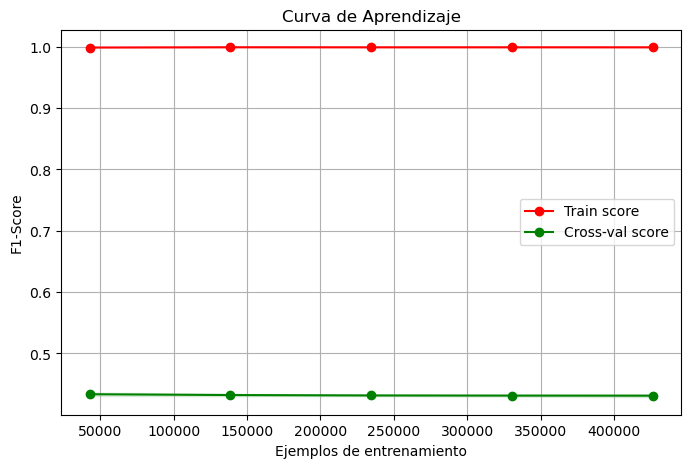

In [66]:
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=np.linspace(.1, 1.0, 5),
        scoring='f1'
    )
    
    plt.figure(figsize=(8,5))
    plt.title(title)
    plt.xlabel("Ejemplos de entrenamiento")
    plt.ylabel("F1-Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-val score")
    
    plt.legend(loc="best")
    plt.show()

# Graficar para el mejor modelo
plot_learning_curve(best_model, "Curva de Aprendizaje", X_train, y_train)

In [67]:
# Función mejorada para evaluación
def extended_evaluation(model, X_train, y_train, X_test, y_test):
    # Entrenamiento
    model.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilidades
    y_train_proba = model.predict_proba(X_train)[:,1]
    y_test_proba = model.predict_proba(X_test)[:,1]
    
    # Métricas
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision': precision_score(y_train, y_train_pred),
            'recall': recall_score(y_train, y_train_pred),
            'f1': f1_score(y_train, y_train_pred),
            'roc_auc': roc_auc_score(y_train, y_train_proba)
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred),
            'roc_auc': roc_auc_score(y_test, y_test_proba)
        },
        'difference': {
            'accuracy': accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred),
            'f1': f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred),
            'roc_auc': roc_auc_score(y_train, y_train_proba) - roc_auc_score(y_test, y_test_proba)
        }
    }
    
    return metrics

# Evaluación extendida del mejor modelo
best_model_metrics = extended_evaluation(best_model, X_train, y_train, X_test, y_test)

# Mostrar resultados
print("\nEVALUACIÓN COMPLETA DEL MEJOR MODELO:")
print("\nMétricas en Train:")
print(f"Accuracy: {best_model_metrics['train']['accuracy']:.4f}")
print(f"Precision: {best_model_metrics['train']['precision']:.4f}")
print(f"Recall: {best_model_metrics['train']['recall']:.4f}")
print(f"F1-Score: {best_model_metrics['train']['f1']:.4f}")
print(f"ROC AUC: {best_model_metrics['train']['roc_auc']:.4f}")

print("\nMétricas en Test:")
print(f"Accuracy: {best_model_metrics['test']['accuracy']:.4f}")
print(f"Precision: {best_model_metrics['test']['precision']:.4f}")
print(f"Recall: {best_model_metrics['test']['recall']:.4f}")
print(f"F1-Score: {best_model_metrics['test']['f1']:.4f}")
print(f"ROC AUC: {best_model_metrics['test']['roc_auc']:.4f}")

print("\nDiferencias (Train - Test):")
print(f"Accuracy: {best_model_metrics['difference']['accuracy']:.4f}")
print(f"F1-Score: {best_model_metrics['difference']['f1']:.4f}")
print(f"ROC AUC: {best_model_metrics['difference']['roc_auc']:.4f}")


EVALUACIÓN COMPLETA DEL MEJOR MODELO:

Métricas en Train:
Accuracy: 0.9995
Precision: 0.9998
Recall: 0.9985
F1-Score: 0.9992
ROC AUC: 1.0000

Métricas en Test:
Accuracy: 0.7103
Precision: 0.5190
Recall: 0.3725
F1-Score: 0.4337
ROC AUC: 0.7614

Diferencias (Train - Test):
Accuracy: 0.2892
F1-Score: 0.5655
ROC AUC: 0.2385


In [68]:
# Validación cruzada para el mejor modelo
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')

print("\nResultados de Validación Cruzada (F1-Score):")
print(f"Scores: {cv_scores}")
print(f"Media: {np.mean(cv_scores):.4f}")
print(f"Desviación estándar: {np.std(cv_scores):.4f}")

# Comparar con el score en test
test_f1 = best_model_metrics['test']['f1']
print(f"\nDiferencia entre CV y Test: {np.mean(cv_scores) - test_f1:.4f}")


Resultados de Validación Cruzada (F1-Score):
Scores: [0.43006217 0.42672769 0.43426726 0.43362427 0.43241063]
Media: 0.4314
Desviación estándar: 0.0027

Diferencia entre CV y Test: -0.0023


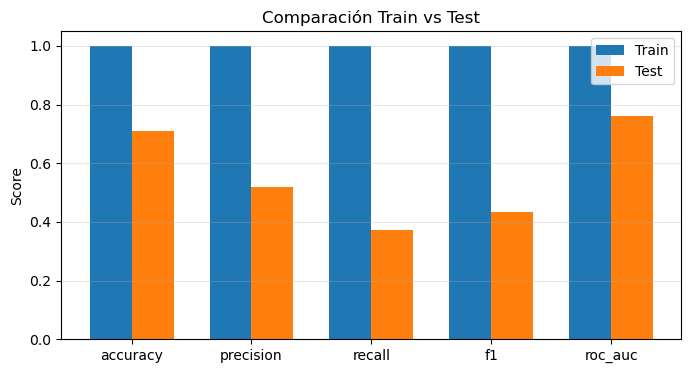

In [69]:
# Gráfico comparativo de métricas
metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
train_values = [best_model_metrics['train'][m] for m in metrics_to_compare]
test_values = [best_model_metrics['test'][m] for m in metrics_to_compare]

x = np.arange(len(metrics_to_compare))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, train_values, width, label='Train')
plt.bar(x + width/2, test_values, width, label='Test')
plt.xticks(x, metrics_to_compare)
plt.ylabel('Score')
plt.title('Comparación Train vs Test')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.show()

### Guardar Modelo

In [70]:
#Preprocesamiento
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['puntos_de_loyalty', 'edad','zona_sucursal','longitud_descripcion','prob_churn','tiempo_atencion']),
    ('cat', OneHotEncoder(), ['segmento_cliente', 'tipo_asistencia',])
])

In [71]:
#Modelo (Random Forest Optimizado)
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    ))
])

In [72]:
if not hasattr(best_model, 'fit'):
    raise ValueError("El objeto best_model no es un estimador válido de scikit-learn")

try:
    best_model.predict(X_test[:1])
except NotFittedError:
    print("El modelo no está entrenado. Ejecutando fit...")
    best_model.fit(X_train, y_train) 


El modelo no está entrenado. Ejecutando fit...


In [73]:
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_optimal = (y_proba >= 0.35).astype(int)

In [74]:
# 4. Verificar resultados
print("\nDistribución de predicciones con umbral 0.36:")
distribucion = pd.Series(y_pred_optimal).value_counts(normalize=True) * 100
print(distribucion.map("{:.2f}%".format))


Distribución de predicciones con umbral 0.36:
1    67.92%
0    32.08%
Name: proportion, dtype: object


<b>Nota</b> Previo a guardar este modelo, da una relacion de 51 vs 49, si se usa los parametros que dice el randomsearch. Pero tarda mas. Por ende se decidio usar el modelo sin hiperparametros.

In [75]:
#Guardar modelo 
joblib.dump(best_model, 'modelo_entrenado1.pkl')

['modelo_entrenado1.pkl']

Tras desarrollar el modelo y realizar los análisis previos, se ha observado que existen clientes que solicitan ser atendidos exclusivamente en una sola zona. Sin embargo, en lo que respecta al tipo de asistencia, los puntos de fidelidad, la probabilidad de churn y los segmentos de cliente, estos presentan variaciones significativas.
Por esta razón, se ha decidido construir un nuevo modelo que permita evaluar de manera más precisa el rendimiento, y que se enfoque en un único tipo de segmento de cliente, un tipo de asistencia y una probabilidad de churn. Este cambio responde a que aproximadamente el 40% de los clientes mostraron variaciones en estos factores.